### Проект №3 "О вкусной и здоровой пище"

#### Импорт библиотек 

In [1]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
import seaborn as sns
from emoji import UNICODE_EMOJI
import pandas_profiling
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
random.seed(42)
np.random.seed(42)
pd.set_option('display.max_columns', 200)

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


#### Функции

In [3]:
def edit_cuisine(x): 
    if type(x) == float:
        return x
    return x[1:-1].strip(' ').split(', ')


def from_reviews_date(x): #извлечение даты из отзывов
    l = []
    z = x[:-2].split('], [')[1].split(', ')
    for i in range(len(z)):
        l.append(z[i])
    return l


def is_emoji(s): # наличие смайлов
    decode = s.encode('unicode-escape')
    l = [c for c in s if c in UNICODE_EMOJI['en']]
    if len(l) > 0:
        return 1
    return 0


def tonal(s): # определение тональности
    s = s.lower()
    for i in bag_of_words['positive']:
        if s.count(i):
            return('positive')
    for i in bag_of_words['negative']:
        if s.count(i):
            return('negative')
    return('neutral')


def is_popular(x):
    if type(x) == float:
        return 0
    for i in x:
        if i in top_kit:
            return 1
    return 0


def is_rare(x):
    if type(x) == float:
        return 0
    for i in x:
        if i in rare_kit:
            return 1
    return 0


def is_alco(x): 
    for i in alco:
        if str(x).count(i):
            return 1
        return 0


def borders_of_outliers(x): # функция поиска доверительных интервалов
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{}, {}].".format(f, l))
    return f, l



#### Импорт данных

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR + '/main_task.csv')
df_test = pd.read_csv(DATA_DIR + 'kaggle_task.csv')


In [5]:
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [6]:
display(df_train.head())
display(df_test.head())

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0


#### Анализ данных по переменным

##### 1) Restaurant_id

In [7]:
display(df_train['Restaurant_id'].apply(lambda x: float(x[3:])).head(5))


0    5569.0
1    1535.0
2     352.0
3    3456.0
4     615.0
Name: Restaurant_id, dtype: float64

Значения похожи на значения из столбца Ranking, проведем корреляционный анализ

In [8]:
df_train['Restaurant_id'].apply(lambda x: float(x[3:])).corr(df_train['Ranking'])

0.9999995570800098

Наблюдается высокая корреляция с признаком Ranking. Признак "Restaurant_id" можно удалить из датасета

In [9]:
data.drop('Restaurant_id',axis=1,inplace=True)

##### 2) Cuisine Style

In [10]:
data['Cuisine Style'].value_counts(dropna=False).head()

NaN                       11590
['Italian']                1332
['French']                 1019
['Spanish']                 860
['French', 'European']      503
Name: Cuisine Style, dtype: int64

В датасете присутствует достаточно много пропусков, заполним пропущенные значением "Other"

In [11]:
data['Cuisine Style'].fillna("[Other]",inplace=True)

In [12]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: edit_cuisine(x)) #преобразуем столбец со списком кухонь


top_kit = list(data['Cuisine Style'].explode().value_counts().head(10).index) # создадим список топ кухонь 
rare_kit=list(data['Cuisine Style'].explode().value_counts().tail(35).index) #создадим список наиболее редких кухонь 
alco = ['Bar', 'Pub', 'Wine Bar', 'Brew Pub'] # создадим список c видами баров

#относится ли ресторан к списку самых распространенных кухонь
data['is_popular'] = data['Cuisine Style'].apply(lambda x: is_popular(x)) 
#относится ли ресторан к списку редких кухонь
data['is_rare'] = data['Cuisine Style'].apply(lambda x: is_rare(x))
#относится ли ресторан к списку баров
data["is_alco"] = data['Cuisine Style'].apply(lambda x: is_alco(x))
#количество кухонь представленных в ресторане
data['len'] = data['Cuisine Style'].apply(lambda x: len(x))  


Добавили в датасет следующие признаки: <br>
1) Количество видов кухонь в ресторане <br>
2) Является ли кухня распространенной <br>
3) Является ли кухня уникальной<br>
4) Является ли заведение баром

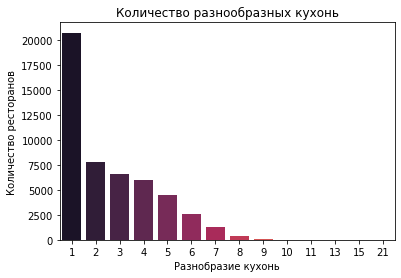

In [13]:
ax=sns.countplot(x='len',data=data,palette='rocket')
ax.set(xlabel='Разнобразие кухонь',ylabel='Количество ресторанов',title='Количество разнообразных кухонь');

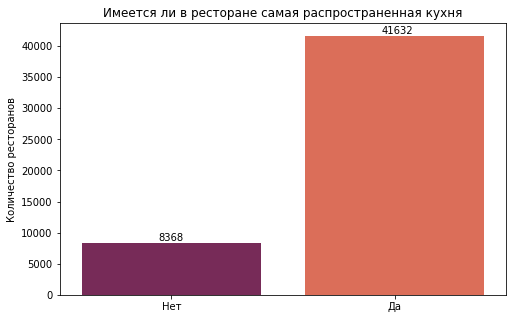

In [14]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x='is_popular',data=data,palette='rocket')
ax.set(xlabel='',ylabel='Количество ресторанов',title='Имеется ли в ресторане самая распространенная кухня',
       xticklabels=('Нет','Да'))
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.34, p.get_height()+350));

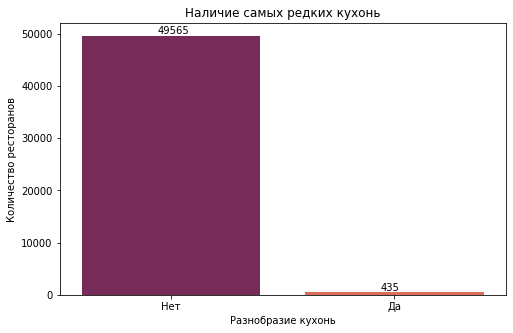

In [15]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x='is_rare',data=data,palette='rocket')
ax.set(xlabel='Разнобразие кухонь',ylabel='Количество ресторанов',title='Наличие самых редких кухонь',
       xticklabels=('Нет','Да'))
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.34, p.get_height()+350));

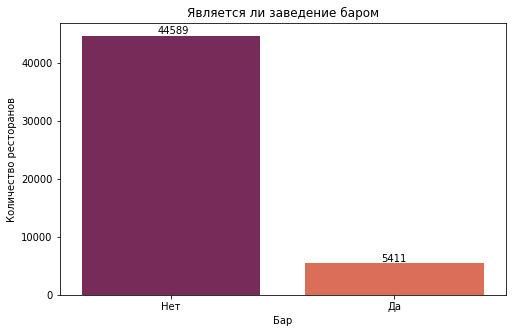

In [16]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x='is_alco',data=data,palette='rocket')
ax.set(xlabel='Бар',ylabel='Количество ресторанов',title='Является ли заведение баром',
       xticklabels=('Нет','Да'))
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.34, p.get_height()+350));

##### 3) Price Range

In [17]:
data['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [18]:
data['Price Range'].replace({'$$ - $$$': 2, '$': 1, '$$$$': 3, }, inplace=True)

В столбце Price Range имеется большое количество пропусков (17361). Заполним пропуски значением 0, так как заполнение модой приведет к еще большему дисбалансу классов

In [19]:
data['Price Range'].value_counts()
data['Price Range'].fillna(0, inplace=True)

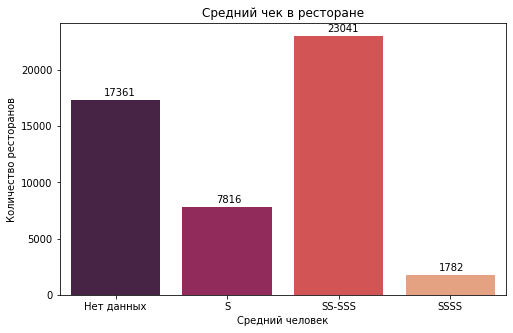

In [20]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x='Price Range',data=data,palette='rocket')
ax.set(xlabel='Средний человек',ylabel='Количество ресторанов',title='Средний чек в ресторане',
       xticklabels=('Нет данных','S','SS-SSS',"SSSS"))
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.3, p.get_height()+350));

##### 4) Number of Reviews

In [21]:
data['Number of Reviews'].value_counts(dropna=False)

NaN       3200
2.0       2403
3.0       2042
4.0       1707
5.0       1471
          ... 
2366.0       1
1757.0       1
4996.0       1
2236.0       1
2297.0       1
Name: Number of Reviews, Length: 1574, dtype: int64

Признак Number of Reviews имеет небольшое количество пропусков (3200). 

In [22]:
data.rename(columns={'Number of Reviews': 'Number_of_Reviews'}, inplace=True)
data['Number_of_Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number_of_Reviews, dtype: float64

<AxesSubplot:xlabel='Number_of_Reviews', ylabel='Count'>

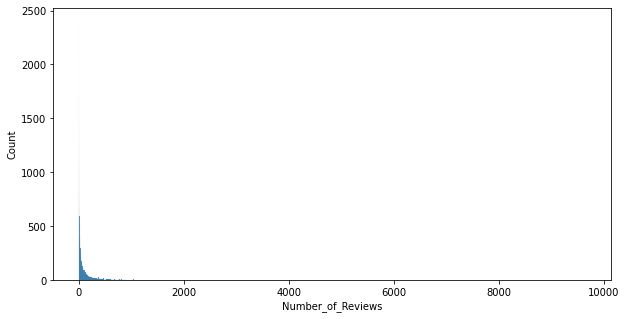

In [23]:
plt.figure(figsize=(10,5))
sns.histplot(data['Number_of_Reviews'],bins=10000)

В качестве эксперимента был произведен парсинг сайта TripAdvisor с целью заполнения пропусков. Но, метрика показала уменьшение точности, возможно это связано с тем что c 2017 года изменилось количество отзывов и это отражается на целевой переменной. Заполним пропущенные значения 1 для последующего логарифмирования

In [24]:
'''from selenium.webdriver import Chrome
keys = ['ID_TA']
webdriver = "chromedriver"
driver = Chrome(webdriver)
url = "https://www.tripadvisor.ru"
for i in range(len(data_without_reviews)):
    c=data_without_reviews["URL_TA"].iloc[i]
    driver.get(f"{url}{c}")
    rev_dict[data_without_reviews["ID_TA"].iloc[i]]=0
    try:
        rev_dict[data_without_reviews["ID_TA"].iloc[i]]=driver.find_element_by_class_name('eBTWs').text.split(' ')[0]
    except:
        continue
reviews_pars=pd.DataFrame(rev_dict.items(),columns=['ID_TA','Number of Reviews'])
data_without_reviews = data_without_reviews.set_index(keys).fillna(reviews_pars.set_index(keys)).reset_index()
data_without_reviews=data_without_reviews[data_without_reviews['Number of Reviews'].isna()]''';

In [25]:
data['Number_of_Reviews'].fillna(1, inplace=True)
#data['Number of Reviews']=data['Number of Reviews']+0.00000001
data['Number_of_Reviews'] = np.log(data['Number_of_Reviews'])

<AxesSubplot:xlabel='Number_of_Reviews', ylabel='Count'>

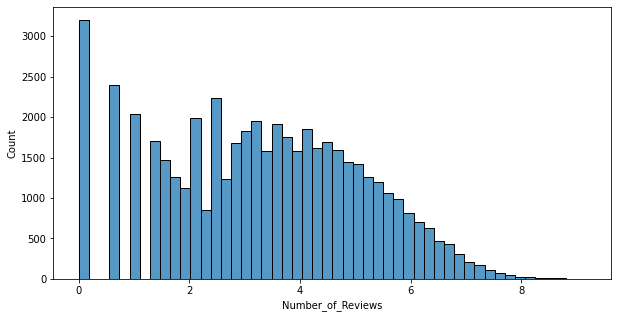

In [26]:
plt.figure(figsize=(10,5))
sns.histplot(data['Number_of_Reviews'],bins=50)

Для удаления выбросов воспользуемся доверительным интервалом. Получилось 7 выбросов. По условию задачи мы не можем удалять строки, заменим аномальные значения пограничными


In [27]:
f=borders_of_outliers(data['Number_of_Reviews'])[1]

25-й перцентиль: 1.9459101490553132, 75-й перцентиль: 4.653960350157523, IQR: 2.7080502011022096,  Границы выбросов: [-2.1161651525980005, 8.716035651810838].


In [28]:
data.loc[data.loc[:,"Number_of_Reviews"]>8.71,'Number_of_Reviews']=f

##### 5) Reviews

In [29]:
data['Reviews'].describe()

count        49998
unique       41857
top       [[], []]
freq          8112
Name: Reviews, dtype: object

В Reviews имеется 2 пропуска заполним их значениями "[[], []]"

In [30]:
data['Reviews'].fillna("[[], []]", inplace=True)

In [31]:
# извлечем из отзывов даты
data['date_1'] = data['Reviews'].apply(lambda x: from_reviews_date(x)[
    0] if (len(x) != 8) else None)
data['date_2'] = data['Reviews'].apply(lambda x: from_reviews_date(
    x)[1] if (len(from_reviews_date(x)) > 1) else None)
data['date_1'] = data['date_1'].apply(lambda x: datetime.strptime(
    x.strip("'"), "%m/%d/%Y") if (x != None) else None)
data['date_2'] = data['date_2'].apply(lambda x: datetime.strptime(
    x.strip("'"), "%m/%d/%Y") if (x != None) else None)

In [32]:
data['date_1'].value_counts(dropna=False)

NaT           8114
2018-01-07     607
2018-01-03     534
2018-01-06     498
2018-01-04     461
              ... 
2013-09-26       1
2013-11-01       1
2013-10-25       1
2012-07-01       1
2012-08-10       1
Name: date_1, Length: 1977, dtype: int64

In [33]:
data['date_2'].value_counts(dropna=False)

NaT           13794
2018-01-03      250
2018-01-04      218
2017-12-30      209
2018-01-01      203
              ...  
2012-05-30        1
2012-04-01        1
2013-06-02        1
2012-11-20        1
2012-07-04        1
Name: date_2, Length: 2070, dtype: int64

В датах имеется много пропусков, посчитаем разницу в днях между отзывами и насколько старыми являются отзывы по сравнению с сегодняшним числом

In [34]:
data["delta"] = (np.abs(data["date_1"]-data["date_2"])).dt.days

In [35]:
data['from_now_1']=data["date_1"].apply(lambda x:(datetime.now()-x).days)
data['from_now_2']=data["date_2"].apply(lambda x:(datetime.now()-x).days)

Заполним пропуски 0

In [36]:
data["delta"].fillna(0,inplace=True)

In [37]:
data["from_now_1"].fillna(0,inplace=True)
data["from_now_2"].fillna(0,inplace=True)

Посмотрим на наличие emoji в отзывах, зачастую смайлы оставляют люди с позитивными отзывами

In [38]:
data['is_smile'] = data['Reviews'].apply(lambda x: is_emoji(str(x)))
#data = pd.get_dummies(data, columns=['len_smile'])

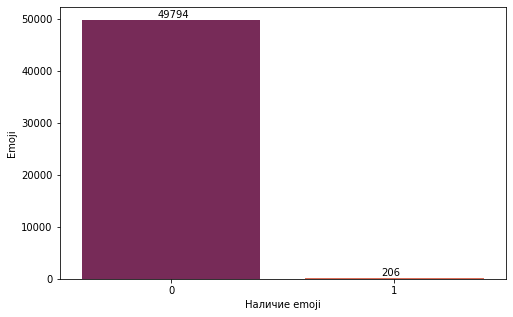

In [39]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x='is_smile',data=data,palette='rocket')
ax.set(xlabel='Наличие emoji',ylabel='Emoji')
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.34, p.get_height()+350));

С помощью  примитивного "мешка слов" определим тональность отзывов

In [40]:
bag_of_words = {'positive': ['excellent', 'best', 'great', 'fantastic', 'wonderful', 'perfect',
                             'delicious', 'amazing', 'honest', 'gem','super'], 
                "negative": ['wasting', 'terrible', 'horrible', 'racism', 'worst','bad','damn','garbage','trash']}
data['tonal'] = data['Reviews'].apply(lambda x: tonal(str(x)))


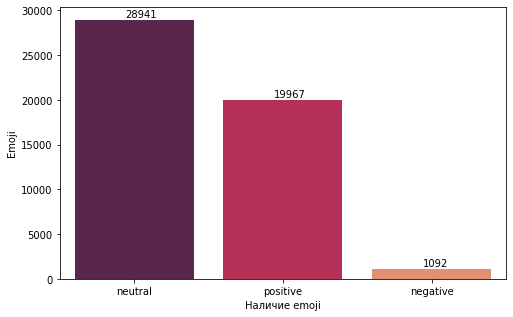

In [41]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x='tonal',data=data,palette='rocket')
ax.set(xlabel='Наличие emoji',ylabel='Emoji')
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.34, p.get_height()+350));

In [42]:
data = pd.get_dummies(data, columns=['tonal'])

##### 6) ID_TA

In [43]:
data['code_ID_TA'] = data['ID_TA'].apply(lambda x: float(x[1:]))

Дополнительно может быть использован для парсинга данных

##### 7) URL_TA


In [44]:
data['code_after_g_URL_TA'] = data['URL_TA'].str.split('-').apply(lambda x: x[1][1:]).astype('float64')

Дополнительно может быть использован для парсинга данных

##### 8) Ranking

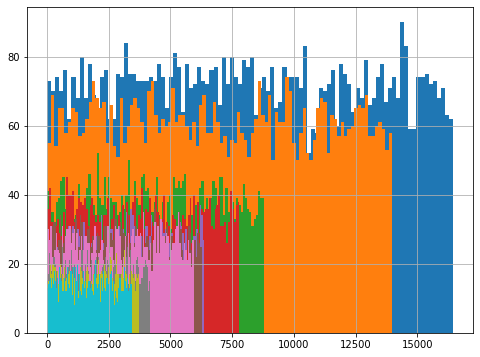

In [45]:
plt.figure(figsize=(8,6))
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Отнормируем значения Ranking в зависимости от количества ресторанов в выборке по городам

In [46]:
sities_count = {}
for k, v in data.groupby('City')['ID_TA'].count().items():
    sities_count[k] = v

In [47]:
data['counts_rest'] = data['City'].apply(lambda x: sities_count[x])
data["coef_Rank"] = data['Ranking']/data['counts_rest']

data.drop('counts_rest', axis=1, inplace=True)

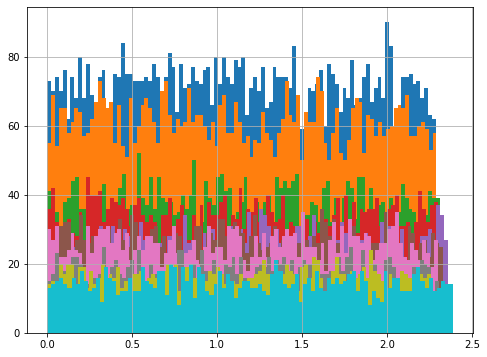

In [48]:
plt.figure(figsize=(8,6))
for x in (data['City'].value_counts())[0:10].index:
    data['coef_Rank'][data['City'] == x].hist(bins=100)
plt.show()

##### 8) City

In [49]:
data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [50]:
 #является ли город столицей
list_Of_NotCapitalCity = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
data['Capital_City'] = data['City'].apply(lambda x: 0.0 if x in list_Of_NotCapitalCity else 1.0)


 #Отношение к какой стране
dict_Сountries = {'London' : 'England', 'Paris' : 'France', 'Madrid' : 'Spain', 
                  'Barcelona' : 'Spain', 'Berlin' : 'Germany', 'Milan' : 'Italy', 
                  'Rome' : 'Italy', 'Prague' : 'Czech_c', 'Lisbon' : 'Portugal', 
                  'Vienna' : 'Austria', 'Amsterdam' : 'Holland', 
                  'Brussels' : 'Belgium', 'Hamburg' : 'Germany', 'Munich' : 'Germany', 
                  'Lyon' : 'France', 'Stockholm' : 'Sweden', 'Budapest' : 'Romania', 
                  'Warsaw' : 'Poland', 'Dublin' : 'Ireland', 'Copenhagen' : 'Denmark', 
                  'Athens' : 'Greece', 'Edinburgh' : 'Scotland', 'Zurich' : 'Switzerland', 
                  'Oporto' : 'Portugal', 'Geneva' : 'Switzerland', 'Krakow' : 'Poland', 
                  'Oslo' : 'Norway', 'Helsinki' : 'Finland', 'Bratislava' : 'Slovakia', 
                  'Luxembourg' : 'Luxembourg_c', 'Ljubljana' : 'Slovenia'}
data['Сountry'] = data.apply(lambda row: dict_Сountries[row['City']], axis = 1)

#Закодируем принадлежность к стране
le = LabelEncoder()
le.fit(data['Сountry'])
data['code_Сountry'] = le.transform(data['Сountry'])
data.drop('Сountry', axis=1, inplace=True)

#Популяция города
dict_Сity_population= {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
data['Сity_population'] = data.apply(lambda row: dict_Сity_population[row['City']], axis = 1)

In [51]:
data = pd.get_dummies(data, columns=['City'])

Добавлены следующие признаки:<br>
1) Является ли город столицей <br>
2) В какой стране находится город<br>
3) Население города

### Финальная обработка данных перед загрузкой в модель

In [52]:
data.drop(['Cuisine Style','Reviews', 'URL_TA', 'ID_TA', 'date_1',"date_2" ], axis=1, inplace=True, errors='ignore')


In [53]:
# функция для стандартизации
def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(data[[d_col]])
    return scaler.transform(data[[d_col]])
# стандартизируем все столбцы кроме целевой и sample
for i  in list(data.columns):
    if i not in ['Rating','sample']:
        data[i] = StandardScaler_column(i)

In [54]:
display(data.describe().head(1)) # Проверяем заполненность всех полей

,Ranking,Price Range,Number_of_Reviews,sample,Rating,is_popular,is_rare,is_alco,len,delta,from_now_1,from_now_2,is_smile,tonal_negative,tonal_neutral,tonal_positive,code_ID_TA,code_after_g_URL_TA,coef_Rank,Capital_City,code_Сountry,Сity_population,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0


In [55]:
my_submissions = df_test['Restaurant_id']

#### Разбиваем датасет на тренировочный и тестовый

In [56]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test = data.query('sample == 0').drop(['sample'], axis=1)


y = train_data.Rating.values            # наш таргет

In [57]:
X = train_data.drop('Rating', axis=1)

In [58]:
test = test.drop('Rating', axis=1)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Обучаем модель, генерируем результат и сравниваем с тестом

In [60]:
regr = RandomForestRegressor(n_estimators=100)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred = np.round(y_pred * 2) / 2

In [61]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.162875


LAST MAE: 0.166625

 BEST   MAE: 0.166625

In [62]:
predictions = regr.predict(test)
predictions = np.round(predictions * 2) / 2

my_submissions = pd.DataFrame(
    {'Restaurant_id': my_submissions.values, 'Rating': predictions})
my_submissions.to_csv('my_submissions.csv', index=False)



In [63]:
my_submissions.head()

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5


Проверяем корреляцию важных переменных

<AxesSubplot:>

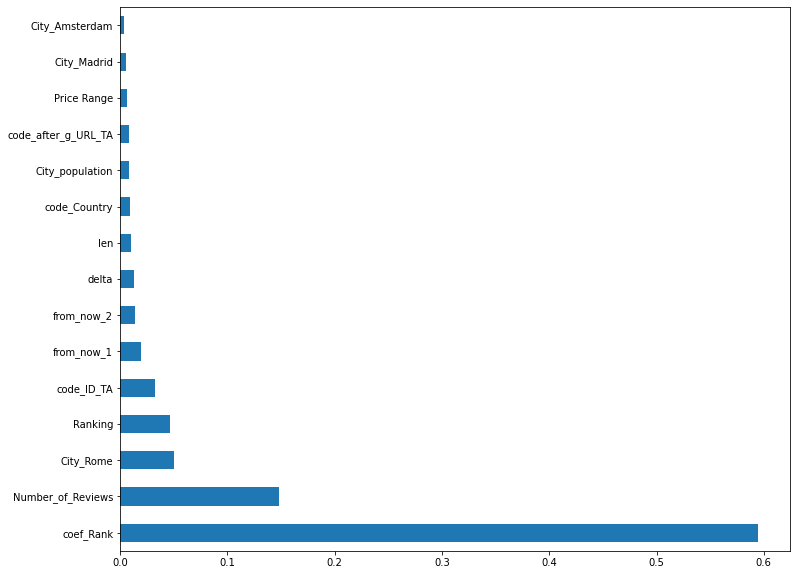

In [64]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (12,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

(15.5, -0.5)

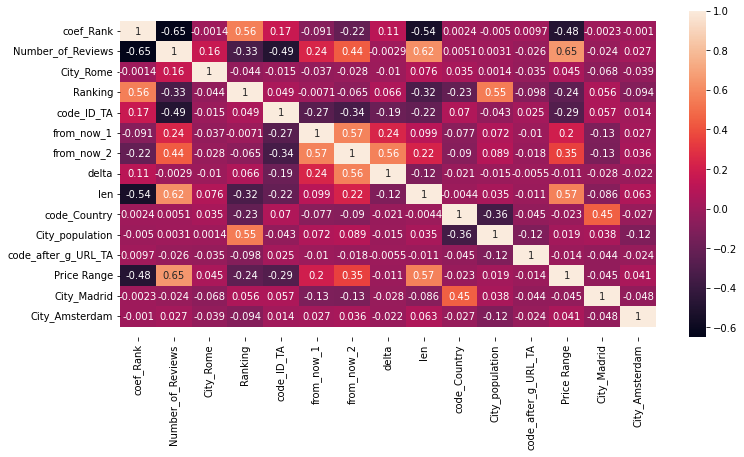

In [65]:
df_temp = data.loc[data['sample'] == 1, list(feat_importances.nlargest(15).index[0:15])]
plt.rcParams['figure.figsize'] = (12,6)
ax = sns.heatmap(df_temp.corr(), annot=True, fmt='.2g')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)